## Agent Supervisor

The [previous example](multi-agent-collaboration.ipynb) routed messages automatically based on the output of the initial researcher agent.

We can also choose to use an LLM to orchestrate the different agents.

Below, we will create an agent group, with an agent supervisor to help delegate tasks.

![diagram](./img/supervisor-diagram.png)

To simplify the code in each agent node, we will use the AgentExecutor class from LangChain. This and other "advanced agent" notebooks are designed to show how you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

Before we build, let's configure our environment:

In [ ]:
# %%capture --no-stderr
# %pip install -U langchain langchain_openai langchain_experimental langsmith pandas

In [1]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

## Create tools

For this example, you will make an agent to do web research with a search engine, and one agent to create plots. Define the tools they'll use below:

In [4]:
from typing import Annotated, List, Tuple, Union

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

## Helper Utilites

Define a helper function below, which make it easier to add new agent worker nodes.

In [3]:
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph


def create_worker_node(
    workflow: StateGraph, name: str, llm: ChatOpenAI, tools: list, system_prompt: str
):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    chain = executor | (
        # So the agents properly role-play in this simulation, we will
        # tag their final message as a human message
        lambda x: {"messages": [HumanMessage(content=x["output"], name=name)]}
    )
    workflow.add_node(name, chain)

## Construct Graph

We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

In [18]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


workflow = StateGraph(AgentState)

llm = ChatOpenAI(model="gpt-4-1106-preview")


create_worker_node(
    workflow, "Researcher", llm, [tavily_tool], "You are a web researcher."
)
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
create_worker_node(
    workflow,
    "Coder",
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data "
    "and generate charts using matplotlib.",
)

Almost done, now create create the team supervisor. It will use function calling to choose the next worker node OR finish processing.

In [19]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

Now connect all the edges in the graph.

In [20]:
workflow.add_node("supervisor", supervisor_chain)


for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

## Invoke the team

With the graph created, we can now invoke it and see how it performs!

In [21]:
results = graph.invoke(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
)
results["messages"][-1].pretty_print()

Python REPL can execute arbitrary code. Use with caution.


================================ Human Message =================================

The "Hello, World!" message has been successfully printed to the terminal.


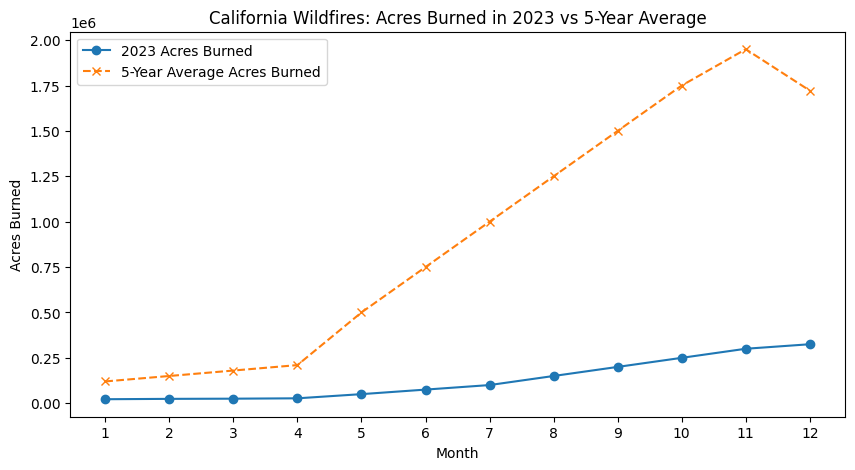

================================ Human Message =================================

The chart has been successfully created and saved as "california_wildfires_comparison.png". This chart compares the acres burned by California wildfires in 2023 to the five-year average for each month. Unfortunately, I'm unable to display the image directly to you here, but the chart visualizes the data with the following characteristics:

- The X-axis represents the months of the year from January to December.
- The Y-axis indicates the acres burned.
- A line graph shows the cumulative acres burned in 2023, marked with circles.
- Another line graph represents the five-year average cumulative acres burned by month, marked with x's and a dashed line.
- The chart includes a legend to distinguish between the two lines and is titled "California Wildfires: Acres Burned in 2023 vs 5-Year Average".

You would need to view the "california_wildfires_comparison.png" file using an image viewer to see the actual char

In [22]:
results = graph.invoke(
    {
        "messages": [
            HumanMessage(
                content="Write a research summary of CA wildfires in 2023. Include a chart."
            )
        ]
    }
)
results["messages"][-1].pretty_print()